# Basic iterative methods

This notebook covers some basic iterative methods: Jacobi, weighted Jacobi, and Gauss Seidel, comparing the convergence rate and their behavior with respect to frequency.

## Jacobi

In [10]:
import numpy
import scipy.sparse
from math import pi
from matplotlib import pyplot
%matplotlib inline

def L2_residual(phi, f):
    """
    Computes the L2-norm of the residual
    Inputs:
    -------
      phi: (numpy.array of floats) solution vector
        f: (numpy.array of floats) RHS
    Returns:
    --------
        L2_norm: (float) L2 norm of the residual
    """
    A_phi = numpy.zeros(len(phi)-2) # stores dot(A,phi)
    A_phi[1:-1] = 2*phi[2:-2] - phi[1:-3] - phi[3:-1]
    A_phi[0] = 2*phi[1] - phi[2]
    A_phi[-1] = 2*phi[-2] - phi[-3]

    res = f - A_phi
    L2_norm = numpy.sqrt(numpy.sum(res*res))
    
    return L2_norm
    

def jacobi(phi, f, BC1, BC2, tol, max_iter):
    """
    Solves a 1D Poisson equation with Jacobi and Dirichlet BCs
    Inputs:
    -------
        phi: (array of float) solution vector
        f  : (array of float) RHS vector
        BC1: (float) boundary condition at 0
        BC2: (float) boundary condition at L
        tol: (float) tolerance
    max_iter: (int) max number of iterations
    Returns:
    --------
        phi: (array of float) solution vector
  res_array: (array of float) array with residual at each iteration
    """
    N = len(phi)
    res = 1.
    res_array = []
    iteration = 0
    while res>tol and iteration<max_iter:
        phi_prev = phi.copy()
        for i in range(1,len(phi)-1):
            phi[i] = 0.5*(f[i-1] + phi_prev[i-1] + phi_prev[i+1])
        phi[0]  = BC1
        phi[-1] = BC2
        res = L2_residual(phi, f)
        res_array.append(res)
        iteration += 1
        
    return phi, res_array
        

### Simple test case

Let's solve this simple test case, where we know the solution is $\sin(x)$:
\begin{align}
-\frac{\partial^2\phi}{\partial x^2} &= \sin x\nonumber\\
\phi(0) &= 0\\
\phi(2\pi) &= 0
\end{align}

As an initial guess, we'll use $\phi(x) = 0$, and we'll discretize in 21 nodes.

In [11]:
N = 51
L = 2*pi
h = L/(N-1)
x = numpy.linspace(0,L,N)
phi_jacobi = numpy.zeros(N)
b = numpy.sin(x[1:-1])

tol = 1e-4
max_iter = 10000

f = b*h*h

phi_jacobi, res_array_jacobi = jacobi(phi_jacobi, f, 0., 0., tol, max_iter)

### Weighted Jacobi

In [12]:
def weight_jacobi(phi, f, BC1, BC2, tol, max_iter, omega):
    """
    Solves a 1D Poisson equation with weighted Jacobi and Dirichlet BCs
    Inputs:
    -------
        phi: (array of float) solution vector
        f  : (array of float) RHS vector
        BC1: (float) boundary condition at 0
        BC2: (float) boundary condition at L
        tol: (float) tolerance
    max_iter: (int) max number of iterations
    Returns:
    --------
        phi: (array of float) solution vector
  res_array: (array of float) array with residual at each iteration
    """
    N = len(phi)
    res = 1.
    res_array = []
    iteration = 0
    while res>tol and iteration<max_iter:
        phi_prev = phi.copy()
        for i in range(1,len(phi)-1):
            phi_st = 0.5*(f[i-1] + phi_prev[i-1] + phi_prev[i+1])
            phi[i] = (1-omega)*phi_prev[i] + omega*phi_st
        phi[0]  = BC1
        phi[-1] = BC2
        res = L2_residual(phi, f)
        res_array.append(res)
        iteration += 1
        
    return phi, res_array

omega = 2./3
phi_wj = numpy.zeros(N)
phi_wj, res_array_wj = weight_jacobi(phi_wj, f, 0., 0., tol, max_iter, omega)

## Gauss-Seidel

In [13]:
def gauss_seidel(phi, f, BC1, BC2, tol, max_iter):
    """
    Solves a 1D Possion equation with Gauss-Seidel and Dirichlet BCs
    Inputs:
    -------
        phi: (array of float) solution vector
        f  : (array of float) RHS vector
        BC1: (float) boundary condition at 0
        BC2: (float) boundary condition at L
        tol: (float) tolerance
    max_iter: (int) max number of iterations
    Returns:
    --------
        phi: (array of float) solution vector
  res_array: (array of float) array with residual at each iteration
    """
    N = len(phi)
    res = 1.
    res_array = []
    iteration = 0
    while res>tol and iteration<max_iter:
        for i in range(1,len(phi)-1):
            phi[i] = 0.5*(f[i-1] + phi[i-1] + phi[i+1])
        phi[0]  = BC1
        phi[-1] = BC2
        res = L2_residual(phi, f)
        res_array.append(res)
        iteration += 1
        
    return phi, res_array

### Same simple test as before

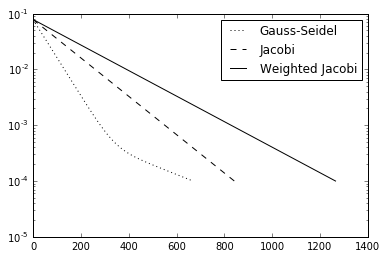

In [14]:
phi_gs = numpy.zeros(N)
phi_gs, res_array_gs = gauss_seidel(phi_gs, f, 0., 0., tol, max_iter)

pyplot.semilogy(res_array_gs, c='k', ls=':', label='Gauss-Seidel')
pyplot.semilogy(res_array_jacobi, c='k', ls='--', label='Jacobi')
pyplot.semilogy(res_array_wj, c='k', ls='-', label='Weighted Jacobi')
pyplot.legend(loc='best');

## Relaxation and frequency

How good are these methods to relax a solution? Let's see how they perform with frequency. We'll start from a function that is a sum of sine waves of different frequencies and see how they relax to zero.

Let's use the initial guess $\phi = \sin(x) + \sin(16x)$, which looks like

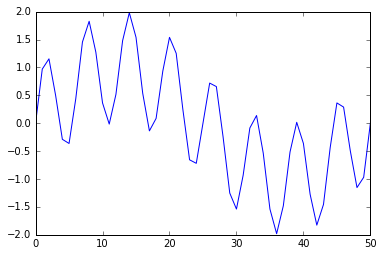

In [15]:
phi = numpy.sin(x) + numpy.sin(8*x)
pyplot.plot(phi)

To relax that to zero, we need to solve a linear system with a zero vector as a RHS. Let's plot the results after 10, 100 and 1000 iterations

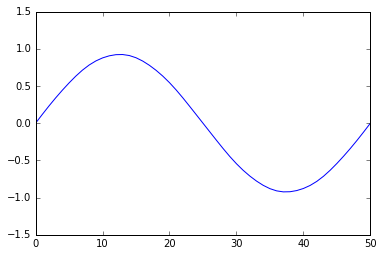

In [16]:
tol = 1e-9
max_iter = 10
phi_10 = phi.copy()
f = numpy.zeros(N-2)
phi_10, res_array_10 = jacobi(phi_10, f, 0., 0., tol, max_iter)
pyplot.plot(phi_10)
pyplot.ylim([-1.5,1.5]);

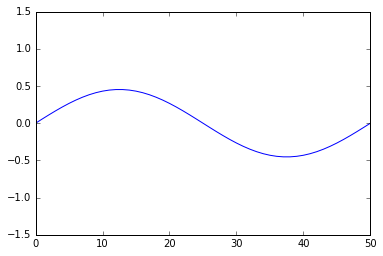

In [17]:
max_iter = 100
phi_100 = phi.copy()
phi_100, res_array_10 = jacobi(phi_100, f, 0., 0., tol, max_iter)
pyplot.plot(phi_100)
pyplot.ylim([-1.5,1.5]);

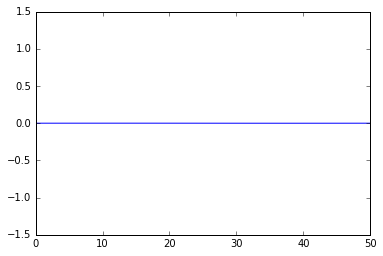

In [18]:
max_iter = 1000
phi_1000 = phi.copy()
phi_1000, res_array_10 = jacobi(phi_1000, f, 0., 0., tol, max_iter)
pyplot.plot(phi_1000)
pyplot.ylim([-1.5,1.5]);

See how it is very efficient at damping out high frequency errors, but very poor at low-frequency errors? Multigrid takes advantage of this! 

Try changing `N=101` to `N=51`. In relative terms, the low-frequency error has a higher frequency with respect to the mesh. See how it is much better at damping errors?